In [85]:
import numpy as np
import os, sys
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import seaborn as sns
from collections import Counter
from tqdm.auto import tqdm, trange
from sklearn.preprocessing import MinMaxScaler
import re
import concurrent.futures
from sklearn.metrics import silhouette_score
from scipy.stats import pearsonr
from collections import OrderedDict
import copy
import pickle
import yaml
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, DistributedSampler
import torch.distributed as dist
from torch.nn.parallel import DistributedDataParallel as DDP
from torchvision import transforms
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import cloudpickle
import ast
from contextlib import contextmanager
from concurrent.futures import ProcessPoolExecutor

from sdv.metadata import SingleTableMetadata
from sdv.evaluation.single_table import evaluate_quality
from sdv.single_table import CTGANSynthesizer
from sdv.sampling import Condition
from sdv.evaluation.single_table import get_column_plot

import dask.dataframe as dpd
import dask_geopandas as dgpd
from dask.diagnostics import ProgressBar
from dask.distributed import Client

import warnings
warnings.filterwarnings('ignore')
np.random.seed(0)

In [2]:
import gc
gc.collect()

40

In [3]:
client = Client(n_workers=100) #128 totally

In [88]:
client.close()

# Coord

In [4]:
coord_gdf = gpd.read_file('../src/coord/coord_gdf.shp')
coord_gdf = coord_gdf.drop(columns=['cell_rmse1', 'cell_r21', 'cell_rmse2', 'cell_r22', 'depth'])

In [5]:
coord_gdf

x             y         ter                         HUC12  \
0      2.933766e+06  1.396557e+07  301.388702                 Cypress Creek   
1      2.934966e+06  1.396557e+07  301.594696                 Cypress Creek   
2      2.933766e+06  1.396437e+07  294.629181                 Cypress Creek   
3      2.934966e+06  1.396437e+07  298.529877                 Cypress Creek   
4      2.936166e+06  1.396437e+07  294.815002                 Cypress Creek   
...             ...           ...         ...                           ...   
26296  3.039069e+06  1.385008e+07   54.643570  Whiteoak Bayou-Buffalo Bayou   
26297  3.039053e+06  1.385088e+07   59.625050             Addicks Reservoir   
26298  3.038396e+06  1.385006e+07   60.055576  Whiteoak Bayou-Buffalo Bayou   
26299  3.038392e+06  1.385087e+07   59.625050             Addicks Reservoir   
26300  3.037707e+06  1.385085e+07   72.228638             Addicks Reservoir   

       region  channel                                           geometry  
0           0        0  POLYGON ((2934366.000 13964974.635, 2933003.17...  
1           0        0  POLYGON ((2934366.000 13967369.160, 2934380.33...  
2           0        0  POLYGON ((2934366.000 13964974.635, 2934366.00...  
3           0        0  POLYGON ((2935566.000 13963774.635, 2934366.00...  
4           0        0  POLYGON ((2936766.000 13963774.635, 2935566.00...  
...       ...      ...                                                ...  
26296       2        1  POLYGON ((3039427.707 13849492.726, 3038745.86...  
26297       3        1  POLYGON ((3039399.212 13851153.541, 3039405.50...  
26298       2        0  POLYGON ((3038723.769 13850469.724, 3038724.68...  
26299       3        0  POLYGON ((3038721.900 13851266.014, 3038723.76...  
26300       3        0  POLYGON ((3037766.475 13851439.564, 3038034.75...  

[26301 rows x 7 columns]

In [6]:
coord_union_gdf = gpd.GeoDataFrame(geometry=[coord_gdf.unary_union], crs=coord_gdf.crs)

# Generated events

In [7]:
syn_events_df = pd.read_parquet('../outputs/aggregated_syn_events.parquet')

In [8]:
syn_events_df

x             y  cumu_rain  peak_int  duration  channel  \
0        3.122392e+06  1.394752e+07   3.713448  3.316965         5        0   
1        3.068903e+06  1.393315e+07   4.668564  3.269290         2        0   
2        3.033544e+06  1.394389e+07   1.984802  1.585991        14        0   
3        3.033464e+06  1.393909e+07   0.941279  0.395483         5        0   
4        3.000083e+06  1.393516e+07   5.070308  2.681067         6        0   
...               ...           ...        ...       ...       ...      ...   
1336615  3.066836e+06  1.390885e+07   1.219238  0.769866         4        1   
1336616  3.164059e+06  1.391041e+07   3.903505  0.698521         6        1   
1336617  3.092509e+06  1.386748e+07   7.844639  2.103962         5        1   
1336618  3.084451e+06  1.390820e+07   2.645236  0.734870         9        1   
1336619  3.046001e+06  1.393646e+07   5.413745  2.718468         5        1   

                ter  syn_depth  
0         90.984207   1.872441  
1        106.370415   1.857054  
2        164.404495   1.634104  
3        157.055893   1.599063  
4        174.948807   1.718153  
...             ...        ...  
1336615  100.226967   1.071834  
1336616   40.256813   1.499436  
1336617   38.867851   1.827506  
1336618   84.812500   1.152786  
1336619  138.093750   1.204867  

[1336620 rows x 8 columns]

# Aggregate events into coord_gdf

In [34]:
coord_dgdf = dgpd.from_geopandas(coord_gdf, npartitions=10)[['channel', 'ter', 'geometry']]
syn_events_gdf = gpd.GeoDataFrame(syn_events_df, geometry=gpd.points_from_xy(syn_events_df['x'], syn_events_df['y']), crs=coord_gdf.crs)
syn_events_dgdf = dgpd.from_geopandas(syn_events_gdf, npartitions=200)[['cumu_rain', 'peak_int', 'duration', 'syn_depth', 'geometry']]
syn_events_w_cell_gdf = syn_events_dgdf.sjoin(coord_dgdf, predicate='within').compute()

In [35]:
syn_events_w_cell_gdf

cumu_rain  peak_int  duration  syn_depth  \
0         3.713448  3.316965         5   1.872441   
1         4.668564  3.269290         2   1.857054   
2         1.984802  1.585991        14   1.634104   
3         0.941279  0.395483         5   1.599063   
4         5.070308  2.681067         6   1.718153   
...            ...       ...       ...        ...   
1336614   0.000000  0.000000        16   1.003747   
1336615   1.219238  0.769866         4   1.071834   
1336616   3.903505  0.698521         6   1.499436   
1336618   2.645236  0.734870         9   1.152786   
1336619   5.413745  2.718468         5   1.204867   

                                 geometry  index_right  channel         ter  
0        POINT (3122392.090 13947521.928)          693        0   90.984207  
1        POINT (3068902.846 13933147.302)         2194        0  106.370415  
2        POINT (3033544.231 13943885.726)         1116        0  164.404495  
3        POINT (3033464.060 13939088.377)         1486        0  157.055893  
4        POINT (3000083.494 13935157.633)         2010        0  174.948807  
...                                   ...          ...      ...         ...  
1336614  POINT (3007589.559 13839269.556)        23703        1   87.031250  
1336615  POINT (3066836.304 13908854.476)        24145        1  100.226967  
1336616  POINT (3164058.607 13910412.494)        24425        1   40.256813  
1336618  POINT (3084451.493 13908204.598)        24163        1   84.812500  
1336619  POINT (3046001.071 13936459.369)        25783        1  138.093750  

[1336149 rows x 8 columns]

In [36]:
syn_events_w_cell_ddf = dpd.from_pandas(syn_events_w_cell_gdf, npartitions=200)
coord_gdf_ddf = dpd.from_pandas(coord_gdf, npartitions=10)
aggregated_df = syn_events_w_cell_ddf.groupby('index_right').agg({
    'cumu_rain': list,
    'peak_int': list,
    'duration': list,
    'syn_depth': list
}).compute()
aggregated_df.columns = [f'{col}_list' for col in aggregated_df.columns if col != 'index_right']
aggregated_df = aggregated_df.reset_index()

coord_gdf_w_distributions = coord_gdf.reset_index().merge(aggregated_df, left_on='index', right_on='index_right', how='left').drop(columns=['index', 'index_right'])

In [37]:
empty_cell_indices = coord_gdf_w_distributions[coord_gdf_w_distributions['duration_list'].isna()].index

In [38]:
coord_gdf_w_distributions.loc[empty_cell_indices, ['cumu_rain_list', 'peak_int_list', 'duration_list', 'syn_depth_list']] = ['[]', '[]', '[]', '[]']

In [39]:
coord_gdf_w_distributions[['cumu_rain_list', 'peak_int_list', 'duration_list', 'syn_depth_list']] = coord_gdf_w_distributions[['cumu_rain_list', 'peak_int_list', 'duration_list', 'syn_depth_list']].astype(str)

In [40]:
coord_gdf_w_distributions.drop(columns=['geometry']).to_parquet('../outputs/coord_w_syn_distributions.parquet')

In [10]:
coord_gdf_w_distributions = gpd.GeoDataFrame(pd.read_parquet('../outputs/coord_w_syn_distributions.parquet'), geometry=coord_gdf['geometry'], crs=coord_gdf.crs)

In [11]:
coord_gdf_w_distributions

x             y         ter                         HUC12  \
0      2.933766e+06  1.396557e+07  301.388702                 Cypress Creek   
1      2.934966e+06  1.396557e+07  301.594696                 Cypress Creek   
2      2.933766e+06  1.396437e+07  294.629181                 Cypress Creek   
3      2.934966e+06  1.396437e+07  298.529877                 Cypress Creek   
4      2.936166e+06  1.396437e+07  294.815002                 Cypress Creek   
...             ...           ...         ...                           ...   
26296  3.039069e+06  1.385008e+07   54.643570  Whiteoak Bayou-Buffalo Bayou   
26297  3.039053e+06  1.385088e+07   59.625050             Addicks Reservoir   
26298  3.038396e+06  1.385006e+07   60.055576  Whiteoak Bayou-Buffalo Bayou   
26299  3.038392e+06  1.385087e+07   59.625050             Addicks Reservoir   
26300  3.037707e+06  1.385085e+07   72.228638             Addicks Reservoir   

       region  channel                                     cumu_rain_list  \
0           0        0  [4.261717701692649, 1.4959194253012689, 2.7302...   
1           0        0  [7.7209288347970855, 5.104717655341985, 2.1935...   
2           0        0                                                 []   
3           0        0                                                 []   
4           0        0  [1.0755354109375177, 12.793700590715742, 1.412...   
...       ...      ...                                                ...   
26296       2        1  [4.612446325787333, 4.570429519923819, 9.99994...   
26297       3        1  [14.642544322390133, 0.661175148861201, 1.6781...   
26298       2        0  [3.298841396328916, 10.956957771228982, 2.6570...   
26299       3        0  [5.856349491341058, 3.751165660160963, 0.89703...   
26300       3        0  [2.0179747248305815, 4.656382972759467, 2.1296...   

                                           peak_int_list  \
0      [3.904449482084619, 0.77255816395237, 0.923203...   
1      [2.521824258852379, 3.154637289548779, 0.44817...   
2                                                     []   
3                                                     []   
4      [0.16023271095298985, 3.305349168738996, 0.508...   
...                                                  ...   
26296  [3.886058443499909, 2.8371771383846136, 2.7812...   
26297  [5.100393193150091, 0.3412274503517189, 0.8149...   
26298  [1.4450330284737454, 4.251772916385593, 0.4532...   
26299  [3.4011183771993405, 2.2037224915302334, 0.379...   
26300  [1.7080136462299729, 1.2373134637512913, 0.497...   

                                           duration_list  \
0                                  [14, 9, 7, 14, 5, 14]   
1                                    [5, 14, 14, 14, 16]   
2                                                     []   
3                                                     []   
4                                          [7, 5, 6, 14]   
...                                                  ...   
26296  [7, 5, 9, 9, 7, 16, 3, 7, 14, 14, 14, 5, 14, 4...   
26297  [6, 5, 7, 7, 4, 9, 9, 3, 4, 7, 7, 5, 7, 6, 14,...   
26298  [9, 14, 14, 16, 14, 7, 14, 7, 5, 5, 4, 6, 5, 4...   
26299  [4, 7, 14, 9, 4, 9, 6, 14, 7, 14, 6, 4, 14, 16...   
26300  [4, 9, 14, 7, 4, 5, 5, 6, 7, 16, 14, 14, 5, 9,...   

                                          syn_depth_list  \
0      [1.3894822597503662, 1.037487268447876, 1.0532...   
1      [1.6728062629699707, 1.1284449100494385, 1.071...   
2                                                     []   
3                                                     []   
4      [1.0152256488800049, 1.2384905815124512, 1.025...   
...                                                  ...   
26296  [1.8712635040283203, 1.6643896102905273, 1.871...   
26297  [1.9932854175567627, 1.193894624710083, 1.3923...   
26298  [1.3853836059570312, 1.890486478805542, 1.3101...   
26299  [1.687591314315796, 1.531592607498169, 1.17666...   
26300  [1.3379802703857422, 1.395181894302

# Get real events distribution

In [14]:
np.random.seed(0)
sample_event_num = 50
event_indices = np.random.choice(range(593), sample_event_num, replace=False)
event_indices


array([240, 132, 571,  92, 170, 449, 573, 471, 187, 229, 181, 239, 587,
       390, 438, 402, 590, 142, 246, 378, 394,  85, 196, 173, 367, 278,
       178,   1, 334, 517,  14, 222, 584, 103, 426, 351,   8, 585, 213,
       320,  21, 379, 118, 250, 282, 516, 557,  48,  52, 336])

In [15]:
scaler = MinMaxScaler()
xy_scaled = scaler.fit_transform(coord_gdf[['x', 'y']])

def load_and_scale(file_path, scale=False):
    df = pd.read_parquet(file_path)[['x', 'y', 'channel', 'ter', 'cumu_rain', 'peak_int', 'duration', 'depth']].reset_index()
    if scale:
        df[['x', 'y']] = xy_scaled
    return df
file_paths = [f'../src/tables/data{i}.parquet' for i in event_indices]
selected_events = [load_and_scale(file) for file in file_paths]
with ProgressBar():
    result = dpd.concat(selected_events, axis=0)
selected_events_df = result.compute()
selected_events_df = selected_events_df.drop(columns=['channel', 'ter', 'depth']).reset_index(drop=True)

In [16]:
selected_events_df

index             x             y  cumu_rain  peak_int  duration
0            0  2.933766e+06  1.396557e+07   0.330646  0.330646         2
1            1  2.934966e+06  1.396557e+07   0.331812  0.331812         2
2            2  2.933766e+06  1.396437e+07   0.321467  0.311706         2
3            3  2.934966e+06  1.396437e+07   0.319289  0.310321         2
4            4  2.936166e+06  1.396437e+07   0.317112  0.308937         2
...        ...           ...           ...        ...       ...       ...
1315045  26296  3.039069e+06  1.385008e+07   0.618965  0.618965         1
1315046  26297  3.039053e+06  1.385088e+07   0.672483  0.672483         1
1315047  26298  3.038396e+06  1.385006e+07   0.642401  0.642401         1
1315048  26299  3.038392e+06  1.385087e+07   0.681234  0.681234         1
1315049  26300  3.037707e+06  1.385085e+07   0.689703  0.689703         1

[1315050 rows x 6 columns]

In [17]:
selected_events_ddf = dpd.from_pandas(selected_events_df, npartitions=100)

In [18]:
real_aggregated_df = selected_events_ddf[['index', 'cumu_rain', 'peak_int', 'duration']].groupby('index').agg({
    'cumu_rain': list,
    'peak_int': list,
    'duration': list
}).compute()

In [19]:
real_aggregated_df = real_aggregated_df.reset_index().sort_values('index')
real_aggregated_df.columns = [col if col == 'index' else f'{col}_list' for col in real_aggregated_df.columns]

In [20]:
coord_gdf['cumu_rain_list'] = real_aggregated_df['cumu_rain_list']
coord_gdf['peak_int_list'] = real_aggregated_df['peak_int_list']
coord_gdf['duration_list'] = real_aggregated_df['duration_list']

In [21]:
coord_gdf

x             y         ter                         HUC12  \
0      2.933766e+06  1.396557e+07  301.388702                 Cypress Creek   
1      2.934966e+06  1.396557e+07  301.594696                 Cypress Creek   
2      2.933766e+06  1.396437e+07  294.629181                 Cypress Creek   
3      2.934966e+06  1.396437e+07  298.529877                 Cypress Creek   
4      2.936166e+06  1.396437e+07  294.815002                 Cypress Creek   
...             ...           ...         ...                           ...   
26296  3.039069e+06  1.385008e+07   54.643570  Whiteoak Bayou-Buffalo Bayou   
26297  3.039053e+06  1.385088e+07   59.625050             Addicks Reservoir   
26298  3.038396e+06  1.385006e+07   60.055576  Whiteoak Bayou-Buffalo Bayou   
26299  3.038392e+06  1.385087e+07   59.625050             Addicks Reservoir   
26300  3.037707e+06  1.385085e+07   72.228638             Addicks Reservoir   

       region  channel                                           geometry  \
0           0        0  POLYGON ((2934366.000 13964974.635, 2933003.17...   
1           0        0  POLYGON ((2934366.000 13967369.160, 2934380.33...   
2           0        0  POLYGON ((2934366.000 13964974.635, 2934366.00...   
3           0        0  POLYGON ((2935566.000 13963774.635, 2934366.00...   
4           0        0  POLYGON ((2936766.000 13963774.635, 2935566.00...   
...       ...      ...                                                ...   
26296       2        1  POLYGON ((3039427.707 13849492.726, 3038745.86...   
26297       3        1  POLYGON ((3039399.212 13851153.541, 3039405.50...   
26298       2        0  POLYGON ((3038723.769 13850469.724, 3038724.68...   
26299       3        0  POLYGON ((3038721.900 13851266.014, 3038723.76...   
26300       3        0  POLYGON ((3037766.475 13851439.564, 3038034.75...   

                                          cumu_rain_list  \
0      [0.33064562687238325, 3.4353019397236944, 3.45...   
1      [0.33181169233243324, 3.5655307458970036, 3.51...   
2      [0.3214672151337218, 3.2914149397798367, 3.565...   
3      [0.3192894373181301, 3.4363269453642724, 3.611...   
4      [0.3171116537581268, 3.581238876783847, 3.6581...   
...                                                  ...   
26296  [0.48749239273425715, 4.111612884896381, 3.906...   
26297  [0.475346273398884, 4.063332796912746, 3.96403...   
26298  [0.572674283161176, 4.024786644238761, 3.79792...   
26299  [0.5628447839842705, 3.9644412596905383, 3.889...   
26300  [0.653602976963968, 3.864159803060928, 3.80940...   

                                           peak_int_list  \
0      [0.33064562687238325, 2.0274635405143604, 1.85...   
1      [0.33181169233243324, 2.0369607281845283, 1.89...   
2      [0.3117059725682517, 1.9273465598215749, 1.925...   
3      [0.3103212984168354, 1.9427784745768615, 1.954...   
4      [0.3089366188200968, 1.9582103508892832, 1.983...   
...                                                  ...   
26296  [0.48749239273425715, 2.5305863431648348, 2.83...   
26297  [0.475346273398884, 2.485630294188475, 2.90337...   
26298  [0.572674283161176, 2.494351202299491, 2.72791...   
26299  [0.5628447839842705, 2.4372635605025863, 2.828...   
26300  [0.653602976963968, 2.3891882374882556, 2.7469...   

                                           duration_list  
0      [2, 4, 5, 2, 3, 4, 2, 5, 4, 1, 1, 14, 1, 1, 3,...  
1      [2, 4, 5, 2, 3, 4, 2, 5, 4, 1, 1, 14, 1, 1, 3,...  
2      [2, 4, 5, 2, 3, 4, 2, 5, 4, 1, 1, 14, 1, 1, 3,...  
3      [2, 4, 5, 2, 3, 4, 2, 5, 4, 1, 1, 14, 1, 1, 3,...  
4      [2, 4, 5, 2, 3, 4, 2, 5, 4, 1, 1, 14, 1, 1, 3,...  
...                                                  ...  
26296  [2, 4, 5, 2, 3, 4, 2, 5, 4, 1, 1, 14, 1, 1, 3,...  
26297  [2, 4, 5, 2, 3, 4, 2, 5, 4, 1, 1, 14, 1, 1, 3,...  
26298  [2, 4, 5, 2, 3, 4, 2, 5, 4, 1, 1, 14, 1, 1, 3,...  
26299  [2, 4, 5, 2, 3, 4, 2, 5, 4, 1, 1, 14, 1, 1, 3,...  
26300  [2, 4, 5, 2, 3, 4, 2, 5, 4, 1, 1, 14, 1, 1, 3,

# Get real events cell attribute distributions

In [35]:
def classify_distribution(df, col_suffix, coef_1=0.25, coef_2=0.25):
    for col in df.columns:
        if col.endswith(col_suffix):
            # Calculate mean and standard deviation for each row
            df[f'{col}_mean'] = df[col].apply(np.mean)
            df[f'{col}_std'] = df[col].apply(np.std)
            
            # Calculate thresholds
            df[f'{col}_thresh_low_medium'] = df[f'{col}_mean'] - coef_1 * df[f'{col}_std']
            df[f'{col}_thresh_medium_high'] = df[f'{col}_mean'] + coef_2 * df[f'{col}_std']
            
            # Classify each element in the list
            def classify(row):
                return [classify_value(x, row[f'{col}_thresh_low_medium'], row[f'{col}_thresh_medium_high']) for x in row[col]]
            
            df[f'{col}_class'] = df.apply(classify, axis=1)
            
            # Create a new column for thresholds
            df[f'{col}_thresh'] = df.apply(lambda row: [row[f'{col}_thresh_low_medium'], row[f'{col}_thresh_medium_high']], axis=1)
            
            # Drop intermediate columns
            df.drop(columns=[f'{col}_mean', f'{col}_std', f'{col}_thresh_low_medium', f'{col}_thresh_medium_high', f'{col}_class'], inplace=True)
    return df

def classify_value(value, thresh_low_medium, thresh_medium_high):
    if value < thresh_low_medium:
        return 'Low'
    elif value <= thresh_medium_high:
        return 'Medium'
    else:
        return 'High'

In [36]:
coord_gdf = classify_distribution(coord_gdf, '_list')

In [37]:
coord_gdf

x             y         ter                         HUC12  \
0      2.933766e+06  1.396557e+07  301.388702                 Cypress Creek   
1      2.934966e+06  1.396557e+07  301.594696                 Cypress Creek   
2      2.933766e+06  1.396437e+07  294.629181                 Cypress Creek   
3      2.934966e+06  1.396437e+07  298.529877                 Cypress Creek   
4      2.936166e+06  1.396437e+07  294.815002                 Cypress Creek   
...             ...           ...         ...                           ...   
26296  3.039069e+06  1.385008e+07   54.643570  Whiteoak Bayou-Buffalo Bayou   
26297  3.039053e+06  1.385088e+07   59.625050             Addicks Reservoir   
26298  3.038396e+06  1.385006e+07   60.055576  Whiteoak Bayou-Buffalo Bayou   
26299  3.038392e+06  1.385087e+07   59.625050             Addicks Reservoir   
26300  3.037707e+06  1.385085e+07   72.228638             Addicks Reservoir   

       region  channel                                           geometry  \
0           0        0  POLYGON ((2934366.000 13964974.635, 2933003.17...   
1           0        0  POLYGON ((2934366.000 13967369.160, 2934380.33...   
2           0        0  POLYGON ((2934366.000 13964974.635, 2934366.00...   
3           0        0  POLYGON ((2935566.000 13963774.635, 2934366.00...   
4           0        0  POLYGON ((2936766.000 13963774.635, 2935566.00...   
...       ...      ...                                                ...   
26296       2        1  POLYGON ((3039427.707 13849492.726, 3038745.86...   
26297       3        1  POLYGON ((3039399.212 13851153.541, 3039405.50...   
26298       2        0  POLYGON ((3038723.769 13850469.724, 3038724.68...   
26299       3        0  POLYGON ((3038721.900 13851266.014, 3038723.76...   
26300       3        0  POLYGON ((3037766.475 13851439.564, 3038034.75...   

                                          cumu_rain_list  \
0      [0.33064562687238325, 3.4353019397236944, 3.45...   
1      [0.33181169233243324, 3.5655307458970036, 3.51...   
2      [0.3214672151337218, 3.2914149397798367, 3.565...   
3      [0.3192894373181301, 3.4363269453642724, 3.611...   
4      [0.3171116537581268, 3.581238876783847, 3.6581...   
...                                                  ...   
26296  [0.48749239273425715, 4.111612884896381, 3.906...   
26297  [0.475346273398884, 4.063332796912746, 3.96403...   
26298  [0.572674283161176, 4.024786644238761, 3.79792...   
26299  [0.5628447839842705, 3.9644412596905383, 3.889...   
26300  [0.653602976963968, 3.864159803060928, 3.80940...   

                                           peak_int_list  \
0      [0.33064562687238325, 2.0274635405143604, 1.85...   
1      [0.33181169233243324, 2.0369607281845283, 1.89...   
2      [0.3117059725682517, 1.9273465598215749, 1.925...   
3      [0.3103212984168354, 1.9427784745768615, 1.954...   
4      [0.3089366188200968, 1.9582103508892832, 1.983...   
...                                                  ...   
26296  [0.48749239273425715, 2.5305863431648348, 2.83...   
26297  [0.475346273398884, 2.485630294188475, 2.90337...   
26298  [0.572674283161176, 2.494351202299491, 2.72791...   
26299  [0.5628447839842705, 2.4372635605025863, 2.828...   
26300  [0.653602976963968, 2.3891882374882556, 2.7469...   

                                           duration_list  \
0      [2, 4, 5, 2, 3, 4, 2, 5, 4, 1, 1, 14, 1, 1, 3,...   
1      [2, 4, 5, 2, 3, 4, 2, 5, 4, 1, 1, 14, 1, 1, 3,...   
2      [2, 4, 5, 2, 3, 4, 2, 5, 4, 1, 1, 14, 1, 1, 3,...   
3      [2, 4, 5, 2, 3, 4, 2, 5, 4, 1, 1, 14, 1, 1, 3,...   
4      [2, 4, 5, 2, 3, 4, 2, 5, 4, 1, 1, 14, 1, 1, 3,...   
...                                                  ...   
26296  [2, 4, 5, 2, 3, 4, 2, 5, 4, 1, 1, 14, 1, 1, 3,...   
26297  [2, 4, 5, 2, 3, 4, 2, 5, 4, 1, 1, 14, 1, 1, 3,...   
26298  [2, 4, 5, 2, 3, 4, 2, 5, 4, 1, 1, 14, 1, 1, 3,...   
26299  [2, 4, 5, 2, 3, 4, 2, 5, 4, 1, 1, 14, 1, 1, 3,...   
26300  [2, 4, 5, 2, 3, 4, 2, 5, 4, 1, 1, 1

In [55]:
def plot_distribution(df, row_idx, col, bins=50):
    row = df.iloc[row_idx]
    col_list = col + '_list'
    # Retrieve the thresholds
    thresh_low_medium, thresh_medium_high = row[f'{col_list}_thresh']
    
    # Separate the values into low, medium, and high based on the thresholds
    low_values = [x for x in row[col_list] if x < thresh_low_medium]
    medium_values = [x for x in row[col_list] if thresh_low_medium <= x <= thresh_medium_high]
    high_values = [x for x in row[col_list] if x > thresh_medium_high]
    
    # Plot the distribution
    plt.hist([low_values, medium_values, high_values], bins=bins, color=['green', 'blue', 'red'], alpha=0.5, label=['Low', 'Medium', 'High'])
    
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.title(f'Real {col.replace("_", " ").upper()} distribution of cell #{row_idx}')
    plt.legend()
    plt.show()


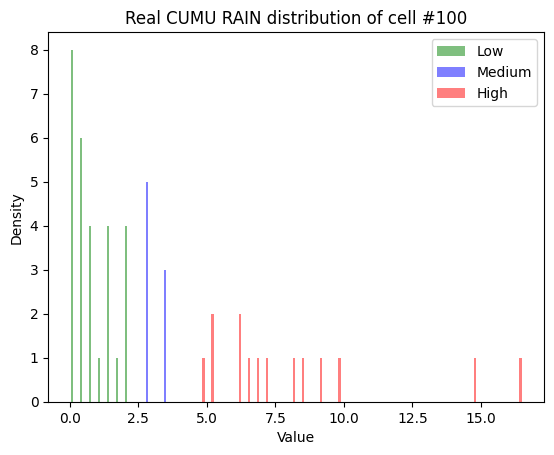

In [56]:
plot_distribution(coord_gdf, 100, 'cumu_rain')

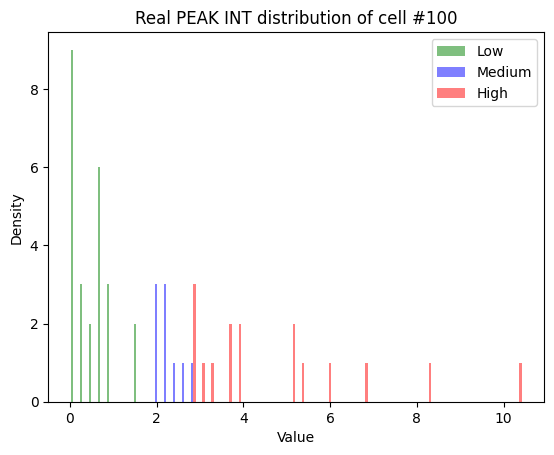

In [57]:
plot_distribution(coord_gdf, 100, 'peak_int')

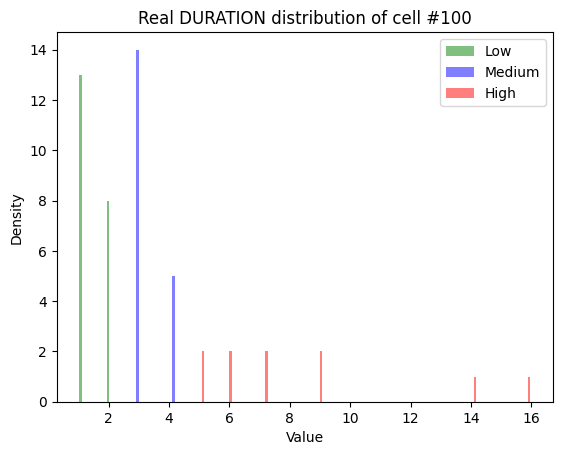

In [58]:
plot_distribution(coord_gdf, 100, 'duration')

# Cluster events

In [59]:
coord_gdf_w_distributions = gpd.GeoDataFrame(pd.read_parquet('../outputs/coord_w_syn_distributions.parquet'), geometry=coord_gdf['geometry'], crs=coord_gdf.crs)

# trans list str to list
distri_lists = ['cumu_rain_list', 'peak_int_list', 'duration_list', 'syn_depth_list']
coord_gdf_w_distributions[distri_lists] = coord_gdf_w_distributions[distri_lists].applymap(lambda x: ast.literal_eval(x) if isinstance(x, str) else [])

In [61]:
coord_gdf_w_distributions['cumu_rain_list_thresh'] = coord_gdf['cumu_rain_list_thresh']
coord_gdf_w_distributions['peak_int_list_thresh'] = coord_gdf['peak_int_list_thresh']
coord_gdf_w_distributions['duration_list_thresh'] = coord_gdf['duration_list_thresh']

In [78]:
coord_gdf_w_distributions['pool'] = [{'Low': [], 'Medium': [], 'High': []} for _ in range(len(coord_gdf_w_distributions))]

In [79]:
def update_pool(row):
    low, medium, high = [], [], []
    for idx in range(len(row['cumu_rain_list'])):
        conditions = [
            row['cumu_rain_list'][idx] <= row['cumu_rain_list_thresh'][0],
            row['peak_int_list'][idx] <= row['peak_int_list_thresh'][0],
            row['duration_list'][idx] <= row['duration_list_thresh'][0]
        ]
        if all(conditions):
            low.append(idx)
            continue  # Skip further checks if already classified as 'Low'

        conditions = [
            row['cumu_rain_list_thresh'][0] < row['cumu_rain_list'][idx] <= row['cumu_rain_list_thresh'][1],
            row['peak_int_list_thresh'][0] < row['peak_int_list'][idx] <= row['peak_int_list_thresh'][1],
            row['duration_list_thresh'][0] < row['duration_list'][idx] <= row['duration_list_thresh'][1]
        ]
        if all(conditions):
            medium.append(idx)
            continue  # Skip further checks if already classified as 'Medium'

        conditions = [
            row['cumu_rain_list'][idx] > row['cumu_rain_list_thresh'][1],
            row['peak_int_list'][idx] > row['peak_int_list_thresh'][1],
            row['duration_list'][idx] > row['duration_list_thresh'][1]
        ]
        if all(conditions):
            high.append(idx)

    return {'Low': low, 'Medium': medium, 'High': high}

# Apply the function to each row
coord_gdf_w_distributions['pool'] = coord_gdf_w_distributions.apply(update_pool, axis=1)


In [80]:
coord_gdf_w_distributions

x             y         ter                         HUC12  \
0      2.933766e+06  1.396557e+07  301.388702                 Cypress Creek   
1      2.934966e+06  1.396557e+07  301.594696                 Cypress Creek   
2      2.933766e+06  1.396437e+07  294.629181                 Cypress Creek   
3      2.934966e+06  1.396437e+07  298.529877                 Cypress Creek   
4      2.936166e+06  1.396437e+07  294.815002                 Cypress Creek   
...             ...           ...         ...                           ...   
26296  3.039069e+06  1.385008e+07   54.643570  Whiteoak Bayou-Buffalo Bayou   
26297  3.039053e+06  1.385088e+07   59.625050             Addicks Reservoir   
26298  3.038396e+06  1.385006e+07   60.055576  Whiteoak Bayou-Buffalo Bayou   
26299  3.038392e+06  1.385087e+07   59.625050             Addicks Reservoir   
26300  3.037707e+06  1.385085e+07   72.228638             Addicks Reservoir   

       region  channel                                     cumu_rain_list  \
0           0        0  [4.261717701692649, 1.4959194253012689, 2.7302...   
1           0        0  [7.7209288347970855, 5.104717655341985, 2.1935...   
2           0        0                                                 []   
3           0        0                                                 []   
4           0        0  [1.0755354109375177, 12.793700590715742, 1.412...   
...       ...      ...                                                ...   
26296       2        1  [4.612446325787333, 4.570429519923819, 9.99994...   
26297       3        1  [14.642544322390133, 0.661175148861201, 1.6781...   
26298       2        0  [3.298841396328916, 10.956957771228982, 2.6570...   
26299       3        0  [5.856349491341058, 3.751165660160963, 0.89703...   
26300       3        0  [2.0179747248305815, 4.656382972759467, 2.1296...   

                                           peak_int_list  \
0      [3.904449482084619, 0.77255816395237, 0.923203...   
1      [2.521824258852379, 3.154637289548779, 0.44817...   
2                                                     []   
3                                                     []   
4      [0.16023271095298985, 3.305349168738996, 0.508...   
...                                                  ...   
26296  [3.886058443499909, 2.8371771383846136, 2.7812...   
26297  [5.100393193150091, 0.3412274503517189, 0.8149...   
26298  [1.4450330284737454, 4.251772916385593, 0.4532...   
26299  [3.4011183771993405, 2.2037224915302334, 0.379...   
26300  [1.7080136462299729, 1.2373134637512913, 0.497...   

                                           duration_list  \
0                                  [14, 9, 7, 14, 5, 14]   
1                                    [5, 14, 14, 14, 16]   
2                                                     []   
3                                                     []   
4                                          [7, 5, 6, 14]   
...                                                  ...   
26296  [7, 5, 9, 9, 7, 16, 3, 7, 14, 14, 14, 5, 14, 4...   
26297  [6, 5, 7, 7, 4, 9, 9, 3, 4, 7, 7, 5, 7, 6, 14,...   
26298  [9, 14, 14, 16, 14, 7, 14, 7, 5, 5, 4, 6, 5, 4...   
26299  [4, 7, 14, 9, 4, 9, 6, 14, 7, 14, 6, 4, 14, 16...   
26300  [4, 9, 14, 7, 4, 5, 5, 6, 7, 16, 14, 14, 5, 9,...   

                                          syn_depth_list  \
0      [1.3894822597503662, 1.037487268447876, 1.0532...   
1      [1.6728062629699707, 1.1284449100494385, 1.071...   
2                                                     []   
3                                                     []   
4      [1.0152256488800049, 1.2384905815124512, 1.025...   
...                                                  ...   
26296  [1.8712635040283203, 1.6643896102905273, 1.871...   
26297  [1.9932854175567627, 1.193894624710083, 1.3923...   
26298  [1.3853836059570312, 1.890486478805542, 1.3101...   
26299  [1.687591314315796, 1.531592607498169, 1.17666...   
26300  [1.3379802703857422, 1.395181894302

In [75]:
coord_gdf_w_distributions['pool']

0                   {'Low': [], 'Medium': [], 'High': [0]}
1                   {'Low': [], 'Medium': [], 'High': [1]}
2                    {'Low': [], 'Medium': [], 'High': []}
3                    {'Low': [], 'Medium': [], 'High': []}
4                   {'Low': [], 'Medium': [], 'High': [1]}
                               ...                        
26296    {'Low': [19], 'Medium': [6], 'High': [9, 17, 26]}
26297            {'Low': [], 'Medium': [], 'High': [0, 9]}
26298    {'Low': [], 'Medium': [10], 'High': [1, 4, 6, ...
26299         {'Low': [], 'Medium': [11], 'High': [5, 21]}
26300    {'Low': [], 'Medium': [40, 43, 53, 54], 'High'...
Name: pool, Length: 26301, dtype: object

In [82]:
def assign_events(row, command):
    pool = row['pool'].get(command, [])
    if pool:
        idx = random.choice(pool)
        row['event_cumu_rain'] = row['cumu_rain_list'][idx]
        row['event_peak_int'] = row['peak_int_list'][idx]
        row['event_duration'] = row['duration_list'][idx]
        row['event_syn_depth'] = row['syn_depth_list'][idx]
    else:
        row['event_cumu_rain'] = -999
        row['event_peak_int'] = -999
        row['event_duration'] = -999
        row['event_syn_depth'] = -999
    return row

In [83]:
coord_gdf_w_distributions = coord_gdf_w_distributions.apply(assign_events, axis=1, command='Low')

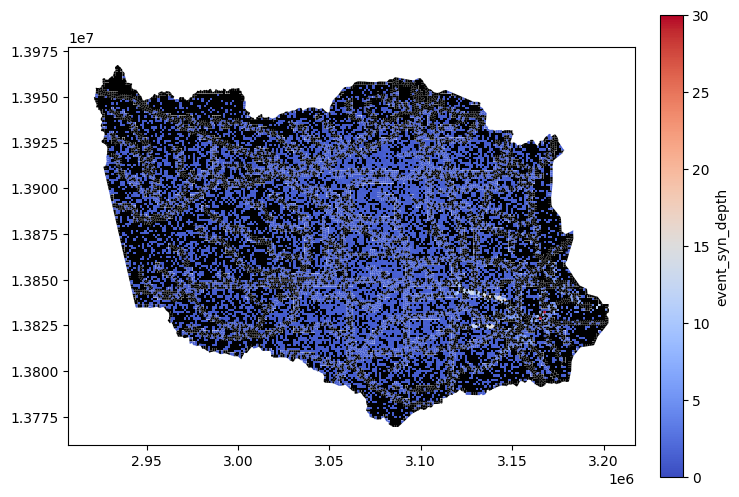

In [89]:

fig, ax = plt.subplots(figsize=(8, 6))
cmap = plt.get_cmap('coolwarm')
colors = cmap(np.linspace(0, 1, cmap.N))
colors = np.vstack([[0, 0, 0, 1], colors])  # Add black color for -999
cmap_with_black = mcolors.LinearSegmentedColormap.from_list('cmap_with_black', colors)
coord_gdf_w_distributions.plot(ax=ax, column='event_syn_depth', cmap=cmap_with_black, vmin=0, vmax=30, legend=False)
norm = Normalize(vmin=0, vmax=30)
sm = ScalarMappable(norm=norm, cmap='coolwarm')
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label('event_syn_depth')

In [98]:
def plot_event_maps(df, command, vmaxs=[5, 5, 3, 30]):
    # Define the custom colormap
    cmap = plt.get_cmap('coolwarm')
    colors = cmap(np.linspace(0, 1, cmap.N))
    colors = np.vstack([[0, 0, 0, 1], colors])  # Add black color for -999
    cmap_with_black = mcolors.LinearSegmentedColormap.from_list('cmap_with_black', colors)

    # Define the columns to plot
    columns = ['event_cumu_rain', 'event_peak_int', 'event_duration', 'event_syn_depth']
    titles = [f'{col.split("event_")[-1].replace("_", " ").upper()} of Synthetic {command} event' for col in columns]

    # Create subplots
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()

    # Plot each column
    for i, (ax, col, title) in enumerate(zip(axes, columns, titles)):
        df.plot(ax=ax, column=col, cmap=cmap_with_black, vmin=0, vmax=vmaxs[i], legend=False)
        norm = Normalize(vmin=0, vmax=vmaxs[i])
        sm = ScalarMappable(norm=norm, cmap='coolwarm')
        sm.set_array([])
        cbar = fig.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
        cbar.set_label(col)
        ax.set_title(title)

    plt.tight_layout()
    plt.show()

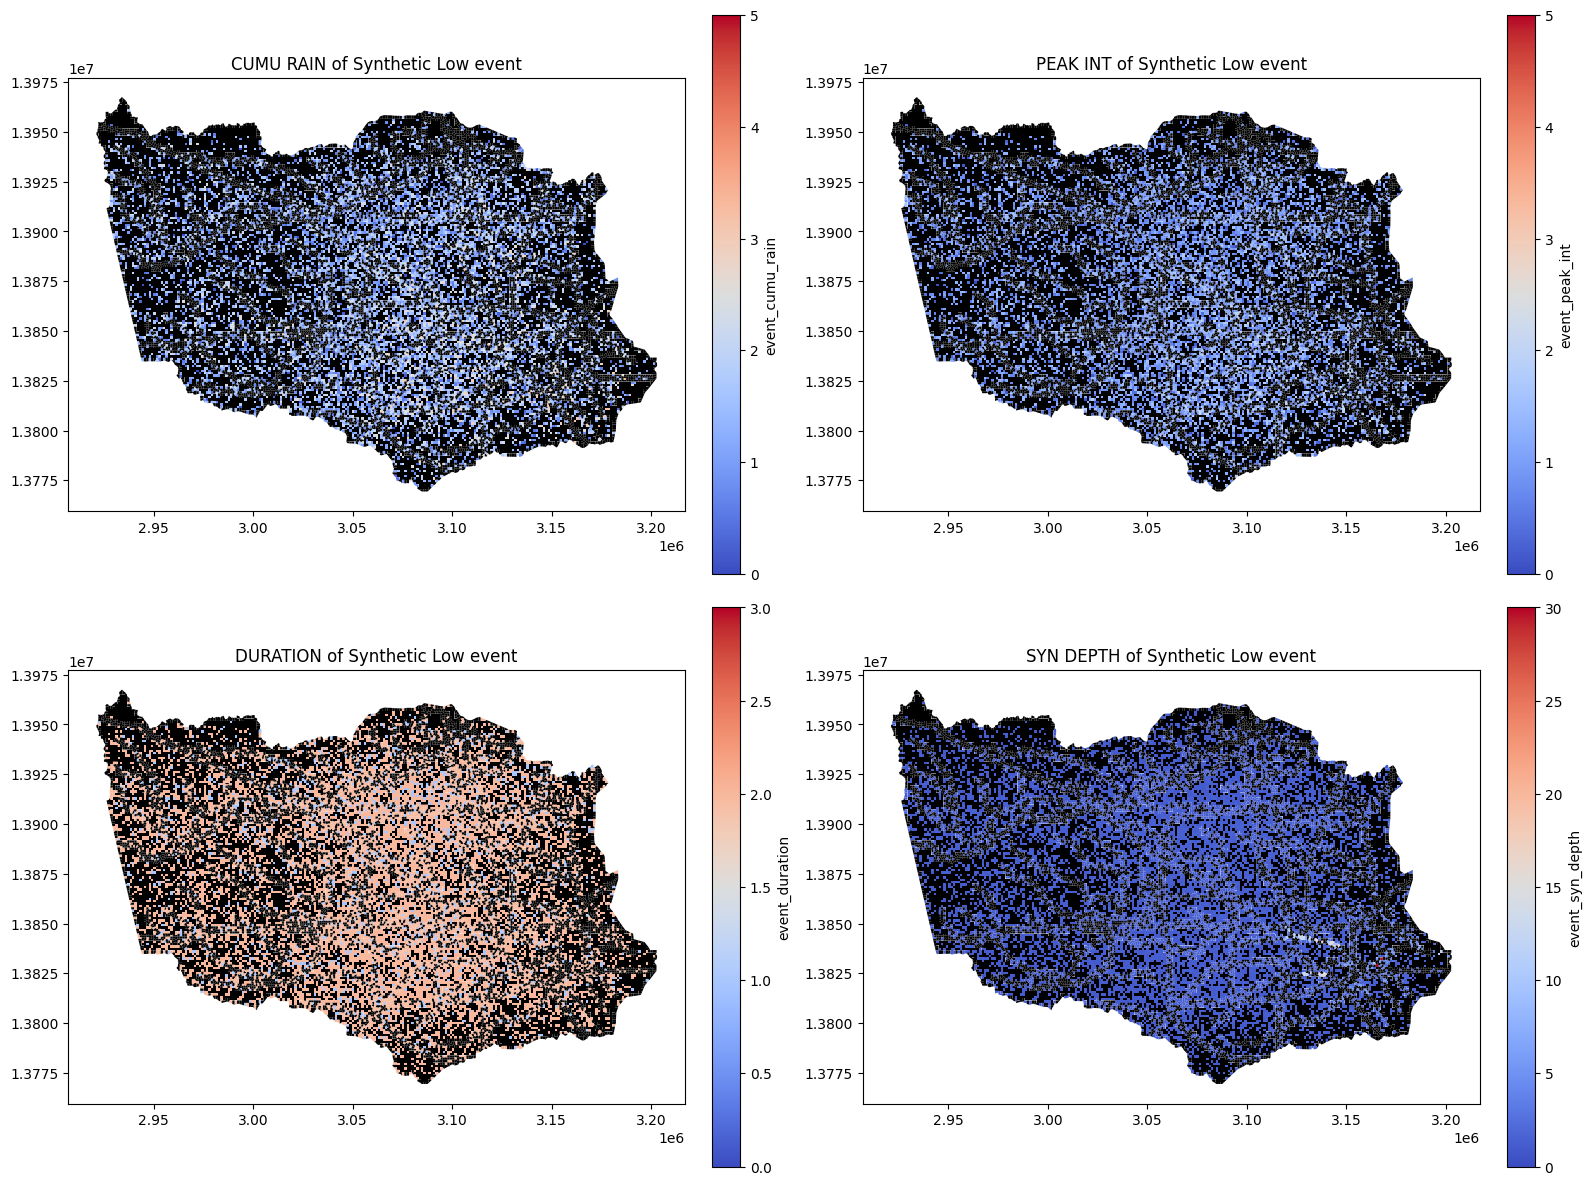

In [99]:
plot_event_maps(coord_gdf_w_distributions, 'Low')

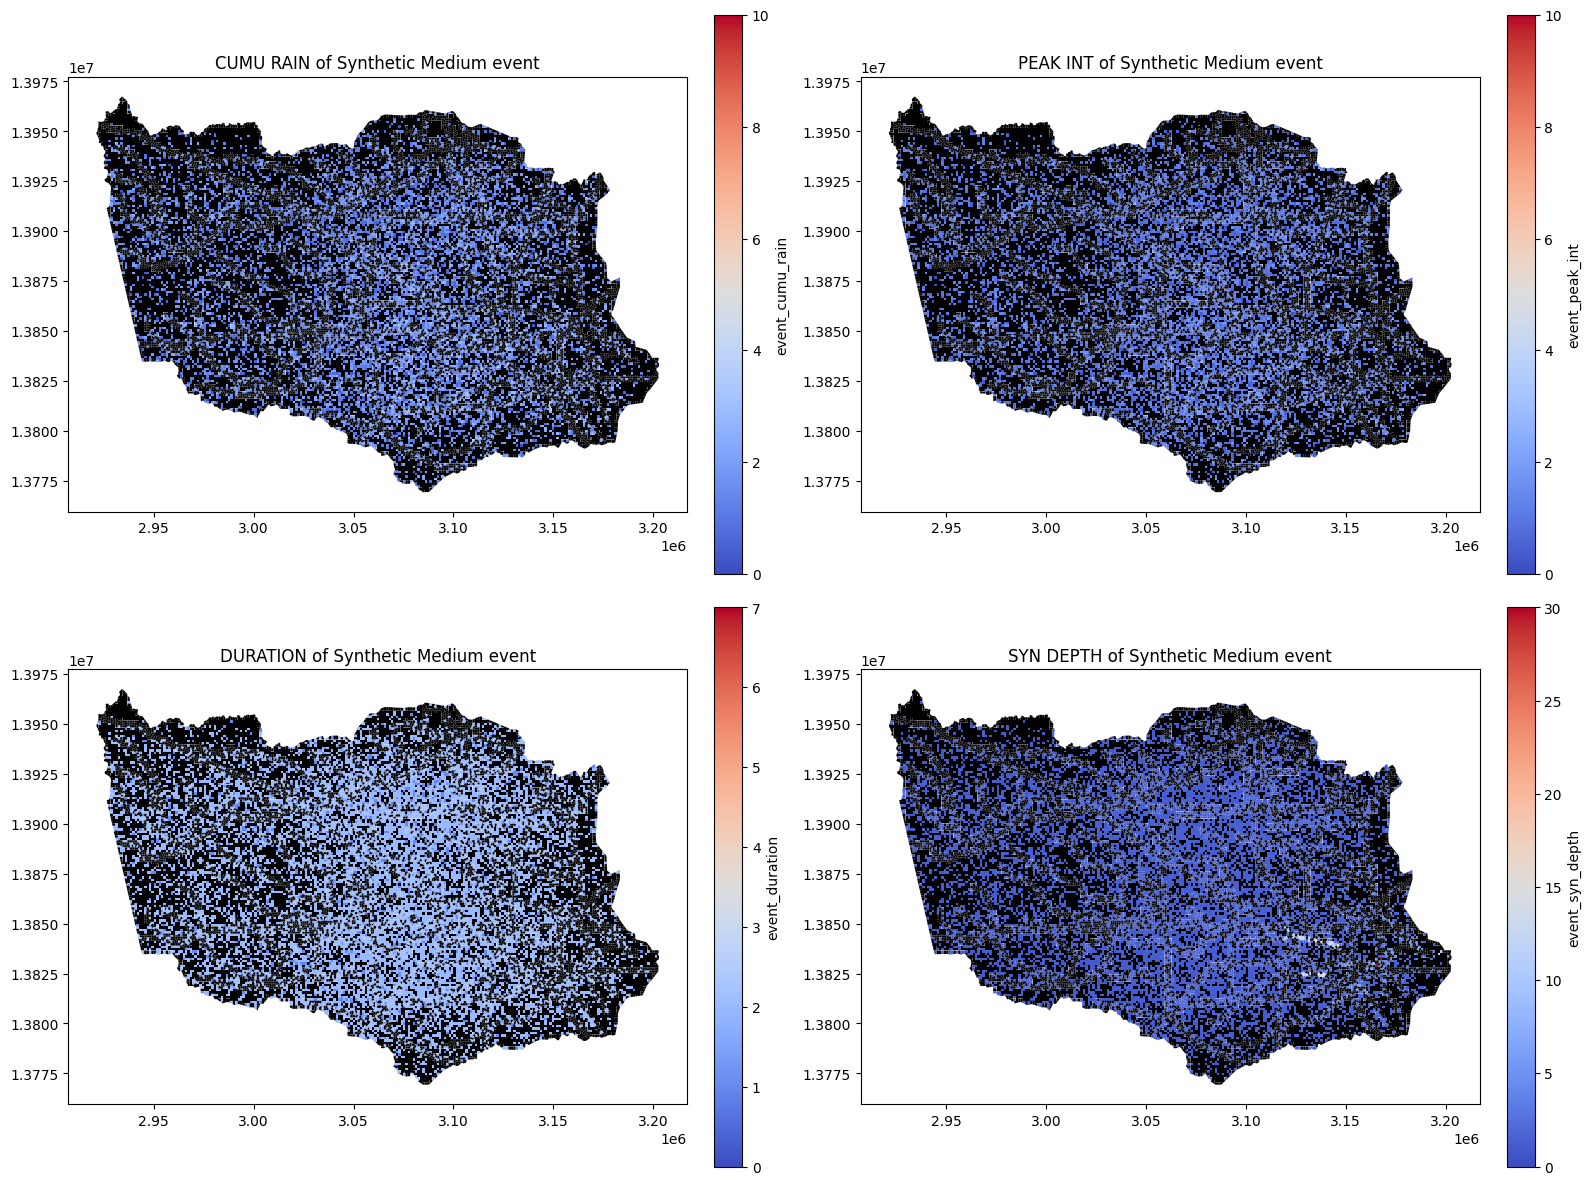

In [100]:
plot_event_maps(coord_gdf_w_distributions, 'Medium', vmaxs=[10, 10, 7, 30])

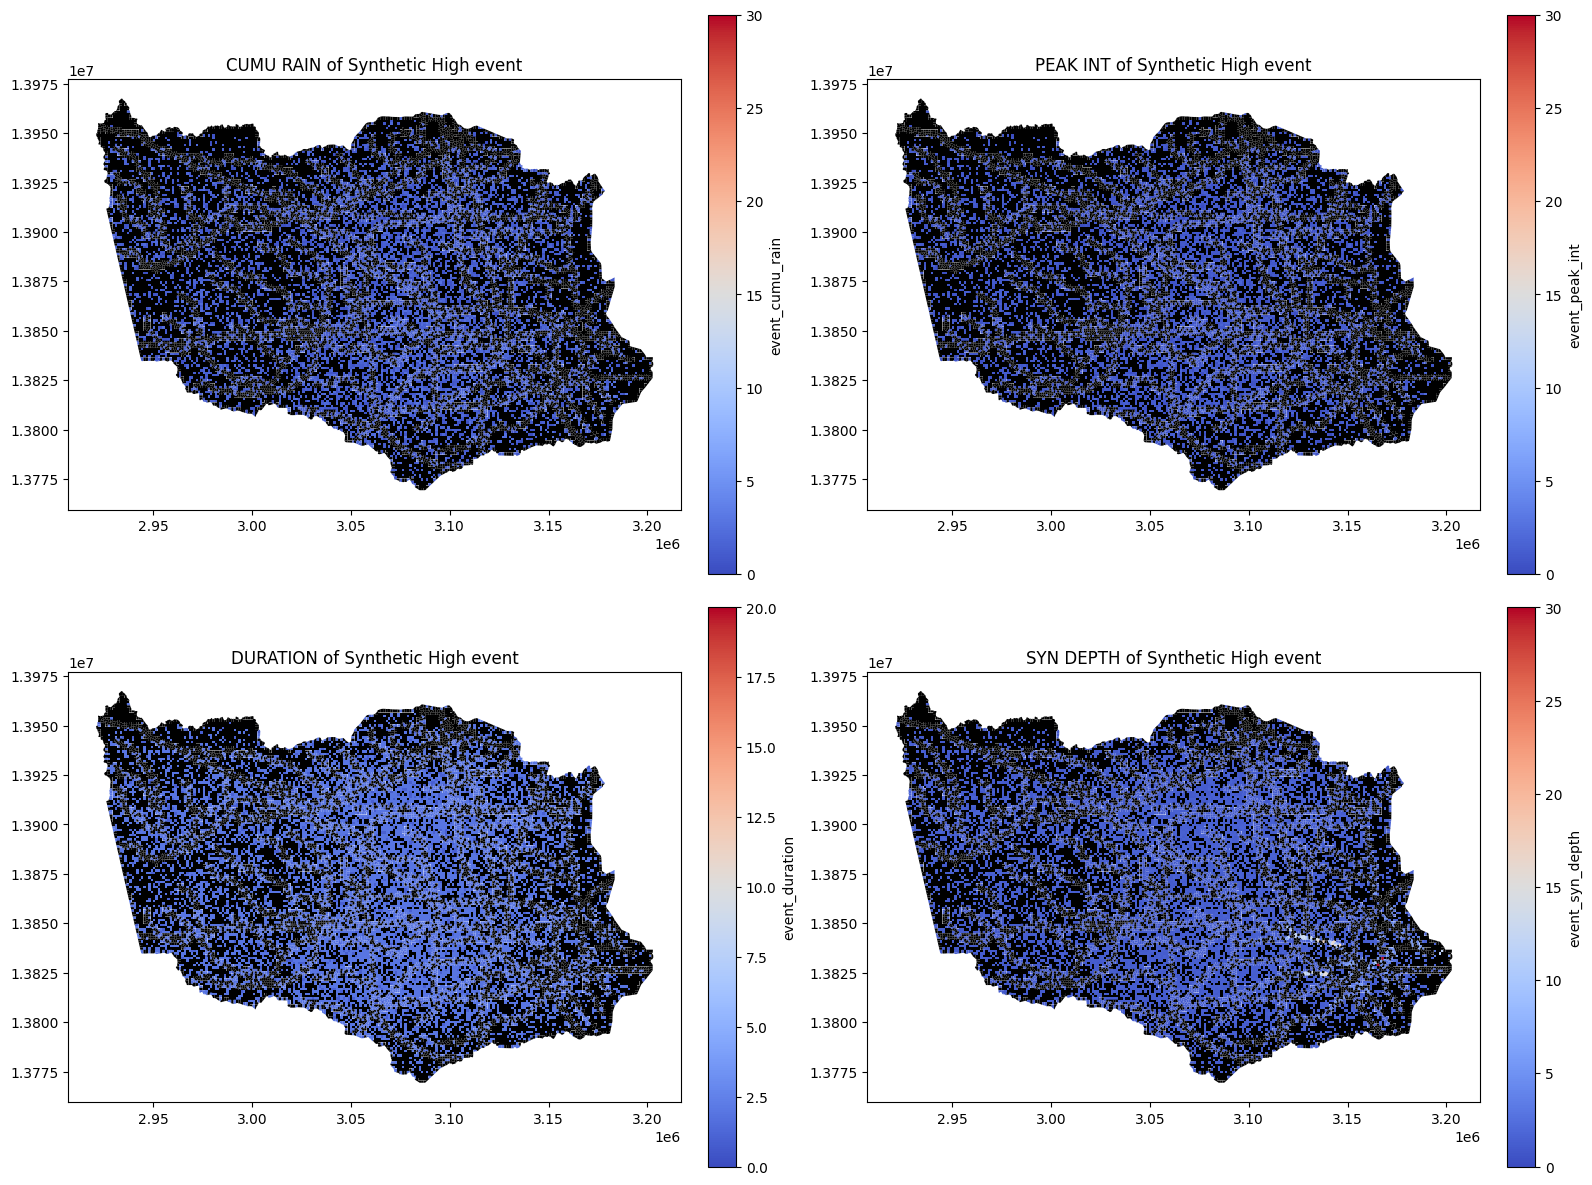

In [101]:
plot_event_maps(coord_gdf_w_distributions, 'High', vmaxs=[30, 30, 20, 30])